In [1]:

import os
import sys

import datetime
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('talk')

from collections import defaultdict

%pylab inline
pylab.rcParams['figure.figsize'] = (14, 6)


Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext watermark
%watermark -a "Bryan Dickinson" -d -t -v -p numpy,pandas

Bryan Dickinson 2019-08-20 12:32:36 

CPython 3.7.3
IPython 7.7.0

numpy 1.16.4
pandas 0.25.0


In [3]:
#Create the path to the data and read into a pandas dataframe


users = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1" )

user_summ = pd.read_csv('takehome_user_engagement.csv',encoding = "ISO-8859-1")

In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
user_summ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


# process user engagement dataframe

In [7]:
#convert time_stamp column to a datetime object
user_summ['time_stamp'] = pd.to_datetime(user_summ['time_stamp'])

In [8]:
#sort values by the time_stamp column, so they are in chronological order
user_summ.sort_values(by = 'time_stamp', inplace = True)
user_summ.reset_index(inplace = True, drop = True)

In [9]:
user_summ.head()

,time_stamp,user_id,visited
0,2012-05-31 08:20:06,10012,1
1,2012-05-31 15:47:36,3428,1
2,2012-05-31 17:19:37,9899,1
3,2012-05-31 21:58:33,1693,1
4,2012-06-01 00:17:30,6102,1


In [10]:
# group by user id, and greate a 'total_visits' feature
visits_by_user = user_summ.groupby('user_id').sum()


In [11]:
def total_visits(row, df):
    ''' function that returns the number of times visited'''
    user = row['user_id']
    return df.loc[user].visited

In [12]:
%%time 

user_summ['ttl_visits'] = user_summ.apply(total_visits, df = visits_by_user, axis = 1)


Wall time: 40.9 s


In [13]:
user_summ.head()

,time_stamp,user_id,visited,ttl_visits
0,2012-05-31 08:20:06,10012,1,1
1,2012-05-31 15:47:36,3428,1,14
2,2012-05-31 17:19:37,9899,1,1
3,2012-05-31 21:58:33,1693,1,289
4,2012-06-01 00:17:30,6102,1,2


In [14]:
# create a dictionary to hold all of the active users
active = defaultdict(lambda: 0)

In [15]:
%%time 


for i in np.arange(len(user_summ)): #for the number of entries in the users summary dataframe
    wk = pd.to_timedelta('7D') #create a weekday variable that holds '7 days'
    
    # create a variable that holds an array of all login dates for a user for each iteration
    dates = user_summ[user_summ.user_id ==user_summ.iloc[i].user_id].time_stamp.values
    
    #if a user is in the dictionary, check if they are in the dictionary with a positive flag 
    #skip and continue with the next user to minimize duplicate computation time
    if active[user_summ.iloc[i].user_id] >0 : continue
    
    # for each date in the user log in array
    for date in np.arange(len(dates)):
        count = 0   # set counter variable to 0
        #take the date and create a range of dates 7 days long
        rng = pd.date_range(start = dates[date], end = pd.to_datetime(dates[date])+wk)
        
        for date in dates: # for each date in the user logins
            if date in rng: #if the date is in the 7 day range
                count +=1 #increment the counter
        if count >= 3: # if the counter is 3 or more
            active[user_summ.iloc[i].user_id] = 1 #set the key to the user_id and the value to 1
                          

Wall time: 43min 49s


In [16]:
#subset the data so show only the users who visited at least 3 times
active_users = user_summ[user_summ.ttl_visits >=3]

In [17]:
def active_users_(x):
    ''' function to replace the value of a column with the active flag'''
    if int(x) in active.keys(): # the user id value is in the active dictionary keys
        return pd.Series(int(x)).replace(active)[0] #replace with the active dictionary flag

def invited(x):
    '''function to create a flag if the user was invited '''
    #if the value ends with 'INVITE' or 'JECTS' (for 'PROJECTS')
    #for the creation value column
    if x.endswith('INVITE') or x.endswith('JECTS'):
        return 1 #return 1
    else:
        return 0 # if not, return 0

def org_size(x):
    '''function that will return the value of an organizations size'''
    if x in np.asarray(users.org_id.unique()): #if the org value is in the list of org sizes
        return pd.Series(int(x)).replace(org_n)[0] #return the organization size
    else:
        return 0 #if the org is not in the list, return 0

# process users dataframe

In [18]:
# create a dictionary of organization numbers & sizes
org_n = users.org_id.value_counts().to_dict()

In [19]:
%%time
#apply the active_users_ function to create the adopted/active users flag feature
users['active'] = users.object_id.apply(active_users_)

#fill NaN values for users that are potentially not in the active dictionary
#those users with <3 logins
users.fillna(value={'active': 0}, inplace = True) 

Wall time: 51min 26s


In [20]:
#observe the distribution of adoptive/active users
users.active.value_counts()

0.0    10344
1.0     1656
Name: active, dtype: int64

In [21]:
#turn the 'create_time' feature into a timestamp
users['creation_time'] = pd.to_datetime(users['creation_time'])

### feature engineering

In [22]:
%%time

#create a 'day' feature that displays what day of the week a user joined
users['day'] = [datetime.datetime.strftime(pd.to_datetime(x), "%a") 
                for x in users.creation_time.values]
#create a 'month' feature that displays what month of the year a user joined
users['month'] = [datetime.datetime.strftime(pd.to_datetime(x), "%b") 
                  for x in users.creation_time.values]
#create a 'week_n' feature that displays what number week of the year a user joined
users['week_n'] = [datetime.datetime.strftime(pd.to_datetime(x), "%U") 
                   for x in users.creation_time.values]


Wall time: 4.81 s


In [23]:
%%time
#apply the invited function to create a feature whether a user was invited or not
users['invited'] = users.creation_source.apply(invited)

Wall time: 15 ms


In [24]:
%%time
#apply the org size feature to create a feature with the size of a users organization
# (how many other users ther are for this user's organization)
users['org_size'] = users.org_id.apply(org_size)


Wall time: 3min 39s


In [25]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active,day,month,week_n,invited,org_size
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0,Tue,Apr,16,1,75
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,Fri,Nov,45,1,233
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0,Tue,Mar,11,1,32
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0,Tue,May,20,1,233
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0,Thu,Jan,02,1,16


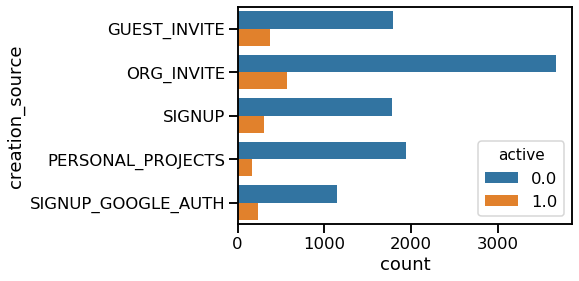

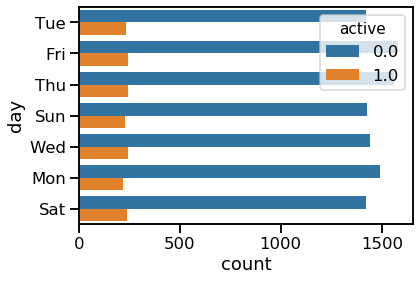

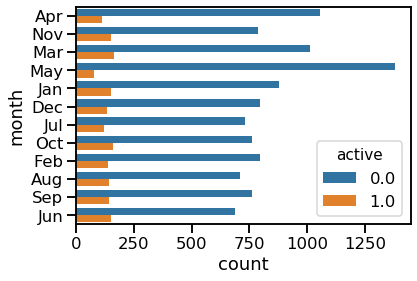

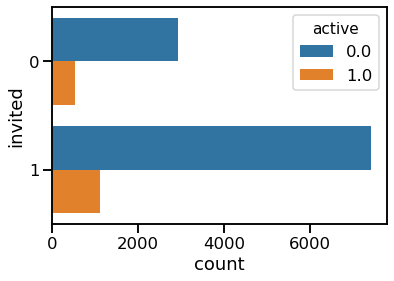

In [26]:
for col in ['creation_source','day', 'month', 'invited']:
    sns.countplot(y = col, hue = 'active', data = users )
    plt.show()

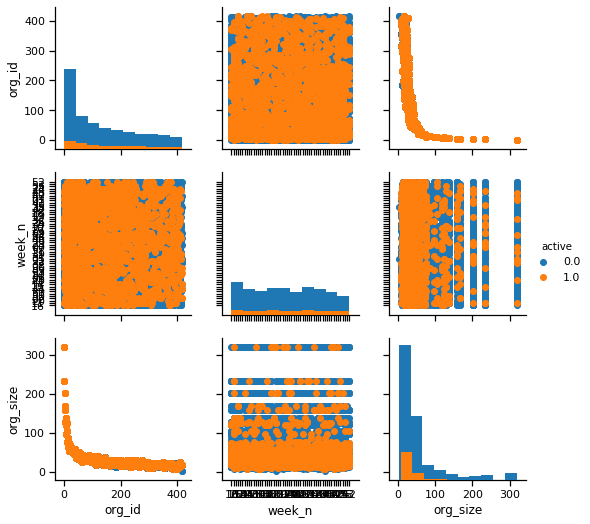

In [27]:
sns.set_context('notebook')
p = sns.PairGrid(users,
                 x_vars = ['org_id','week_n', 'org_size'],
                 y_vars = ['org_id','week_n', 'org_size'],
                 hue = 'active'
                )
p = p.map_diag(plt.hist)
p.map_offdiag(plt.scatter)
p.add_legend()

It appears that there is a pretty similar (even) distribution

In [28]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=None):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


In [29]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active,day,month,week_n,invited,org_size
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0,Tue,Apr,16,1,75
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,Fri,Nov,45,1,233
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0,Tue,Mar,11,1,32
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0,Tue,May,20,1,233
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0,Thu,Jan,02,1,16


In [30]:
df = users.drop(['object_id', 'creation_time', 'name', 
                       'email', 'last_session_creation_time', 
                       'org_id','invited_by_user_id'], axis =1)
df = pd.get_dummies(df, columns = ['day','month','week_n','creation_source'] )
df_cor = get_top_abs_correlations(df)

In [31]:
df_cor = pd.DataFrame(df_cor).reset_index()
df_cor.rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0:"correlation"}, 
           inplace = True)
df_cor = df_cor[(df_cor.feature_1 == 'active') | 
          (df_cor.feature_2 == 'active')].reset_index(drop = True)[0:10]

print("Top 10 Absolute Correlations")
df_cor

Top 10 Absolute Correlations


,feature_1,feature_2,correlation
0,active,month_May,0.090890
1,active,org_size,0.083936
2,active,creation_source_PERSONAL_PROJECTS,0.075717
3,active,week_n_21,0.053894
4,active,week_n_20,0.045975
5,active,creation_source_GUEST_INVITE,0.044317
6,active,week_n_19,0.041150
7,active,month_Apr,0.037744
8,active,creation_source_SIGNUP_GOOGLE_AUTH,0.036198
9,active,month_Jun,0.034964


## Create predictive model

In [32]:
users_df = users.drop(['object_id', 'creation_time', 'name', 
                       'email', 'last_session_creation_time', 
                       'org_id','invited_by_user_id','active' ], axis =1)

In [33]:
#user get_dummies on the categorical values
X = pd.get_dummies(users_df, columns = ['day','month','week_n','creation_source'] )
#set target variable
y = users.active.values

In [34]:
print(y.shape)
print(X.shape)

(12000,)
(12000, 82)


In [35]:
#import relevent classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

#import preprocessing, metrics & pipelines
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

In [36]:
#split the data to test & training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 5, stratify = y)


#build the pipline with upsampling & scaling the data
pipeline = imbPipeline([('sm', SMOTE(random_state = 5,
                                     sampling_strategy = 'not majority')),
               ('clf', GradientBoostingClassifier())
              ])

#paramters for tuning
parameters = [
    {'clf': [GradientBoostingClassifier()],
    'clf__n_estimators': [150, 200],
    'clf__max_depth': [2, 3],
    'clf__min_samples_split': [50]}
]

#create the grid search object
cv = GridSearchCV(pipeline,
                  param_grid=parameters,
                  refit = True,
                  cv = 5,
                  #precision is used to help identify only the relevant data points
                  #due to such a high imbalance of the dataset
                  scoring = 'precision', 
                  verbose = True,
                  n_jobs = -1)

#fit the data
cv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sm',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=5, ratio=None,
                                              sampling_strategy='not majority',
                                              svm_estimator='deprecated')),
                                       ('clf',
                                        GradientBoostingClassifier(criterion='friedman_mse',
                                                                   init=None,
                                                                   learni...
                                                             min_weight_fraction_leaf=0.0,
          

In [37]:
#identify the best classifier and parameters
cv.best_params_

{'clf': GradientBoostingClassifier(criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=2,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=50,
                            min_weight_fraction_leaf=0.0, n_estimators=200,
                            n_iter_no_change=None, presort='auto',
                            random_state=None, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
 'clf__max_depth': 2,
 'clf__min_samples_split': 50,
 'clf__n_estimators': 200}

In [38]:
#predict on the test set
y_pred = cv.predict(X_test)

#capture the prediction probabilities
y_predict_proba = cv.predict_proba(X_test)[:,1]

In [39]:

#scoring metrics
prec_score = cv.score(X_test, y_test)
roc_auc = roc_auc_score(y_test, y_predict_proba)

print('The precision score is: {}'.format(prec_score))
print('The AUC score is: {}'.format(roc_auc))


#print the confusion matrix and classification report from the best model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

The precision score is: 0.20973782771535582
The AUC score is: 0.6392502471383785
[[1858  211]
 [ 275   56]]
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.88      2069
         1.0       0.21      0.17      0.19       331

    accuracy                           0.80      2400
   macro avg       0.54      0.53      0.54      2400
weighted avg       0.78      0.80      0.79      2400



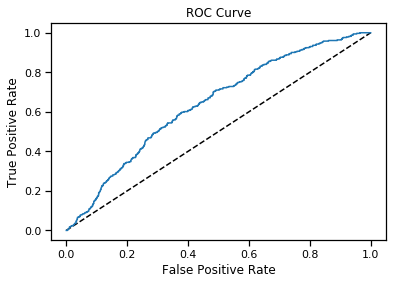

In [40]:
# Generate ROC curve values fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba)

# Plot ROC curve
_=plt.plot([0, 1], [0, 1], 'k--')
_=plt.plot(fpr, tpr)
_=plt.xlabel('False Positive Rate')
_=plt.ylabel('True Positive Rate')
_=plt.title('ROC Curve')
plt.show()

In [41]:

fi = cv.best_estimator_.steps[1][1].feature_importances_

#place the feature importances in a dataframe
feature_importances = pd.DataFrame(fi,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(5)

,importance
month_May,0.104918
org_size,0.069662
month_Apr,0.064973
creation_source_PERSONAL_PROJECTS,0.063979
day_Mon,0.059150


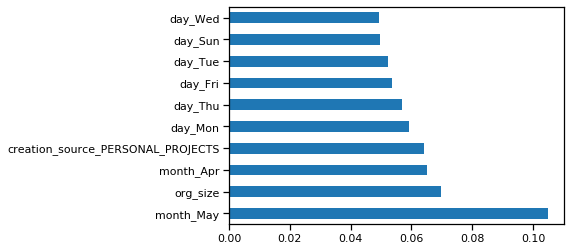

In [42]:
#plot the top 10 feature importances
feat_importances = pd.Series(cv.best_estimator_.steps[1][1].feature_importances_,
                             index=X.columns)

feat_importances.nlargest(10).plot(kind='barh')

plt.show()

The model does not predict the positive class well. The precision is at .21% and the f1 score is .14.

There is a large proportion of users that are non-adoptive. 

I removed a few features, such as 'last logged in time', because this would not be much help to the model. If the user is continually logging in, then of course they will have a high correlation to this model. The goal is to find a few 'controllable' predictors to help increase when the user will 'last log in'.

I added a few features that might be able to help move additional users to 'adoptive'.
- The day a user signed up
- The Week number a user signed up
- Whether the user was invited to the software or not
- how large the organization the person was a part of

From the data the top five predictors from the dataset are:
- Users who joined in May
    - Was there a special event/promotion that happened during this month?
    - Did a new/large account join?
    - This may be something to look into to determine if we are missing a group/subset of customers during this time period.
- The organization size
    - This seems to make sense, larger organizations may have more folks that join and are active
        - Utilize marketing to larger organizations to help increase adoption, assign/offer account managers to help with adoption
- Users who joined in April
    - Same feedback from above with 'May'
- Users who were invited to join another user's personal workspace
    - Provide a campaign targeted at promoting personal projects and enlisting help.
- Users who joined on Thursday
    - Same idea with the 'month' features